## FFT benchmarks
Perform 2D FFT benchmarks using the CUDA and OpenCL backends of pyvkfft,
and compare with scikit-cuda (cuFFT) and gpyfft (clfft) if they are present

*Note 1: this is now more easily done using the `pyvkfft-benchmark` command-line script*

Note 2: in this example, we are using a fixed batch size for 1D and 3D transforms (e.g. 16 arrays transformed in //). This is different from the command-line benchmark, which keeps a fixed total array size (100's of MB). This is why the throughput remains low for small sizes, and then becomes larger than the card's nominal bandwidth because of caching effects, before reaching more normal throughput values.

Note 3: due to a bug, we cannot delete cuFFT plans (or this corrupts the cuda context), so the memory usage will continue to grow during execution. Either do not test cufft (skcuda) or limit the size to avoid this. The command-line script avoids this by using a separate process for each individual test (and is consequently pretty slow).

In [1]:
%matplotlib notebook
gpu_name = None

import os
import platform
import gc
from itertools import permutations

try:
    import pycuda.driver as cu_drv
    import pycuda.gpuarray as cua
    from pycuda import curandom
    import pyvkfft.cuda
    from pyvkfft.cuda import VkFFTApp as  cuVkFFTApp
    from pyvkfft.base import primes
    has_pyvkfft_cuda = True
except ImportError:
    has_pyvkfft_cuda = False

try:
    import pyopencl as cl
    import pyopencl.array as cla
    from pyopencl import clrandom
    import pyvkfft.opencl
    from pyvkfft.opencl import VkFFTApp as clVkFFTApp
    from pyvkfft.base import primes
    has_pyvkfft_opencl = True
except ImportError:
    has_pyvkfft_opencl = False
    
try:
    import pycuda.autoinit
    import pycuda.driver as cu_drv
    import pycuda.gpuarray as cua
    from pycuda import curandom
    import skcuda.fft as cu_fft
    has_skcuda = True
except:
    has_skcuda = False

try:
    import pyopencl as cl
    import pyopencl.array as cla
    from pyopencl import clrandom
    import gpyfft
    has_gpyfft = True
except:
    has_gpyfft = False

import matplotlib.pyplot as plt
import numpy as np
import timeit



/home/esrf/favre/miniconda3/envs/pynx-py311-cu11.7/lib/python3.11/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
gpu_name_real = None
if has_pyvkfft_opencl or has_gpyfft:
    # Create some context on the first available GPU
    if 'PYOPENCL_CTX' in os.environ:
        cl_ctx = cl.create_some_context()
    else:
        cl_ctx = None
        # Find the first OpenCL GPU available and use it, unless
        for p in cl.get_platforms():
            for d in p.get_devices():
                if d.type & cl.device_type.GPU == 0:
                    continue
                gpu_name_real = d.name
                print("Selected OpenCL device: ", d.name)
                cl_ctx = cl.Context(devices=(d,))
                break
            if cl_ctx is not None:
                break
    cq = cl.CommandQueue(cl_ctx)

if has_pyvkfft_cuda or has_skcuda:
    if gpu_name is None:
        d = cu_drv.Device(0)
        gpu_name_real = d.name()
        print("Selected  CUDA  device: ", d.name())
        cu_ctx = d.make_context()
    else:
        for i in range(cu_drv.Device.count()):
            d = cu_drv.Device(i)
            if gpu_name.lower() in d.name().lower():
                gpu_name_real = d.name()
                print("Selected  CUDA  device: ", d.name())
                cu_ctx = d.make_context()
                break


Selected OpenCL device:  NVIDIA A40
Selected  CUDA  device:  NVIDIA A40


<IPython.core.display.Javascript object>


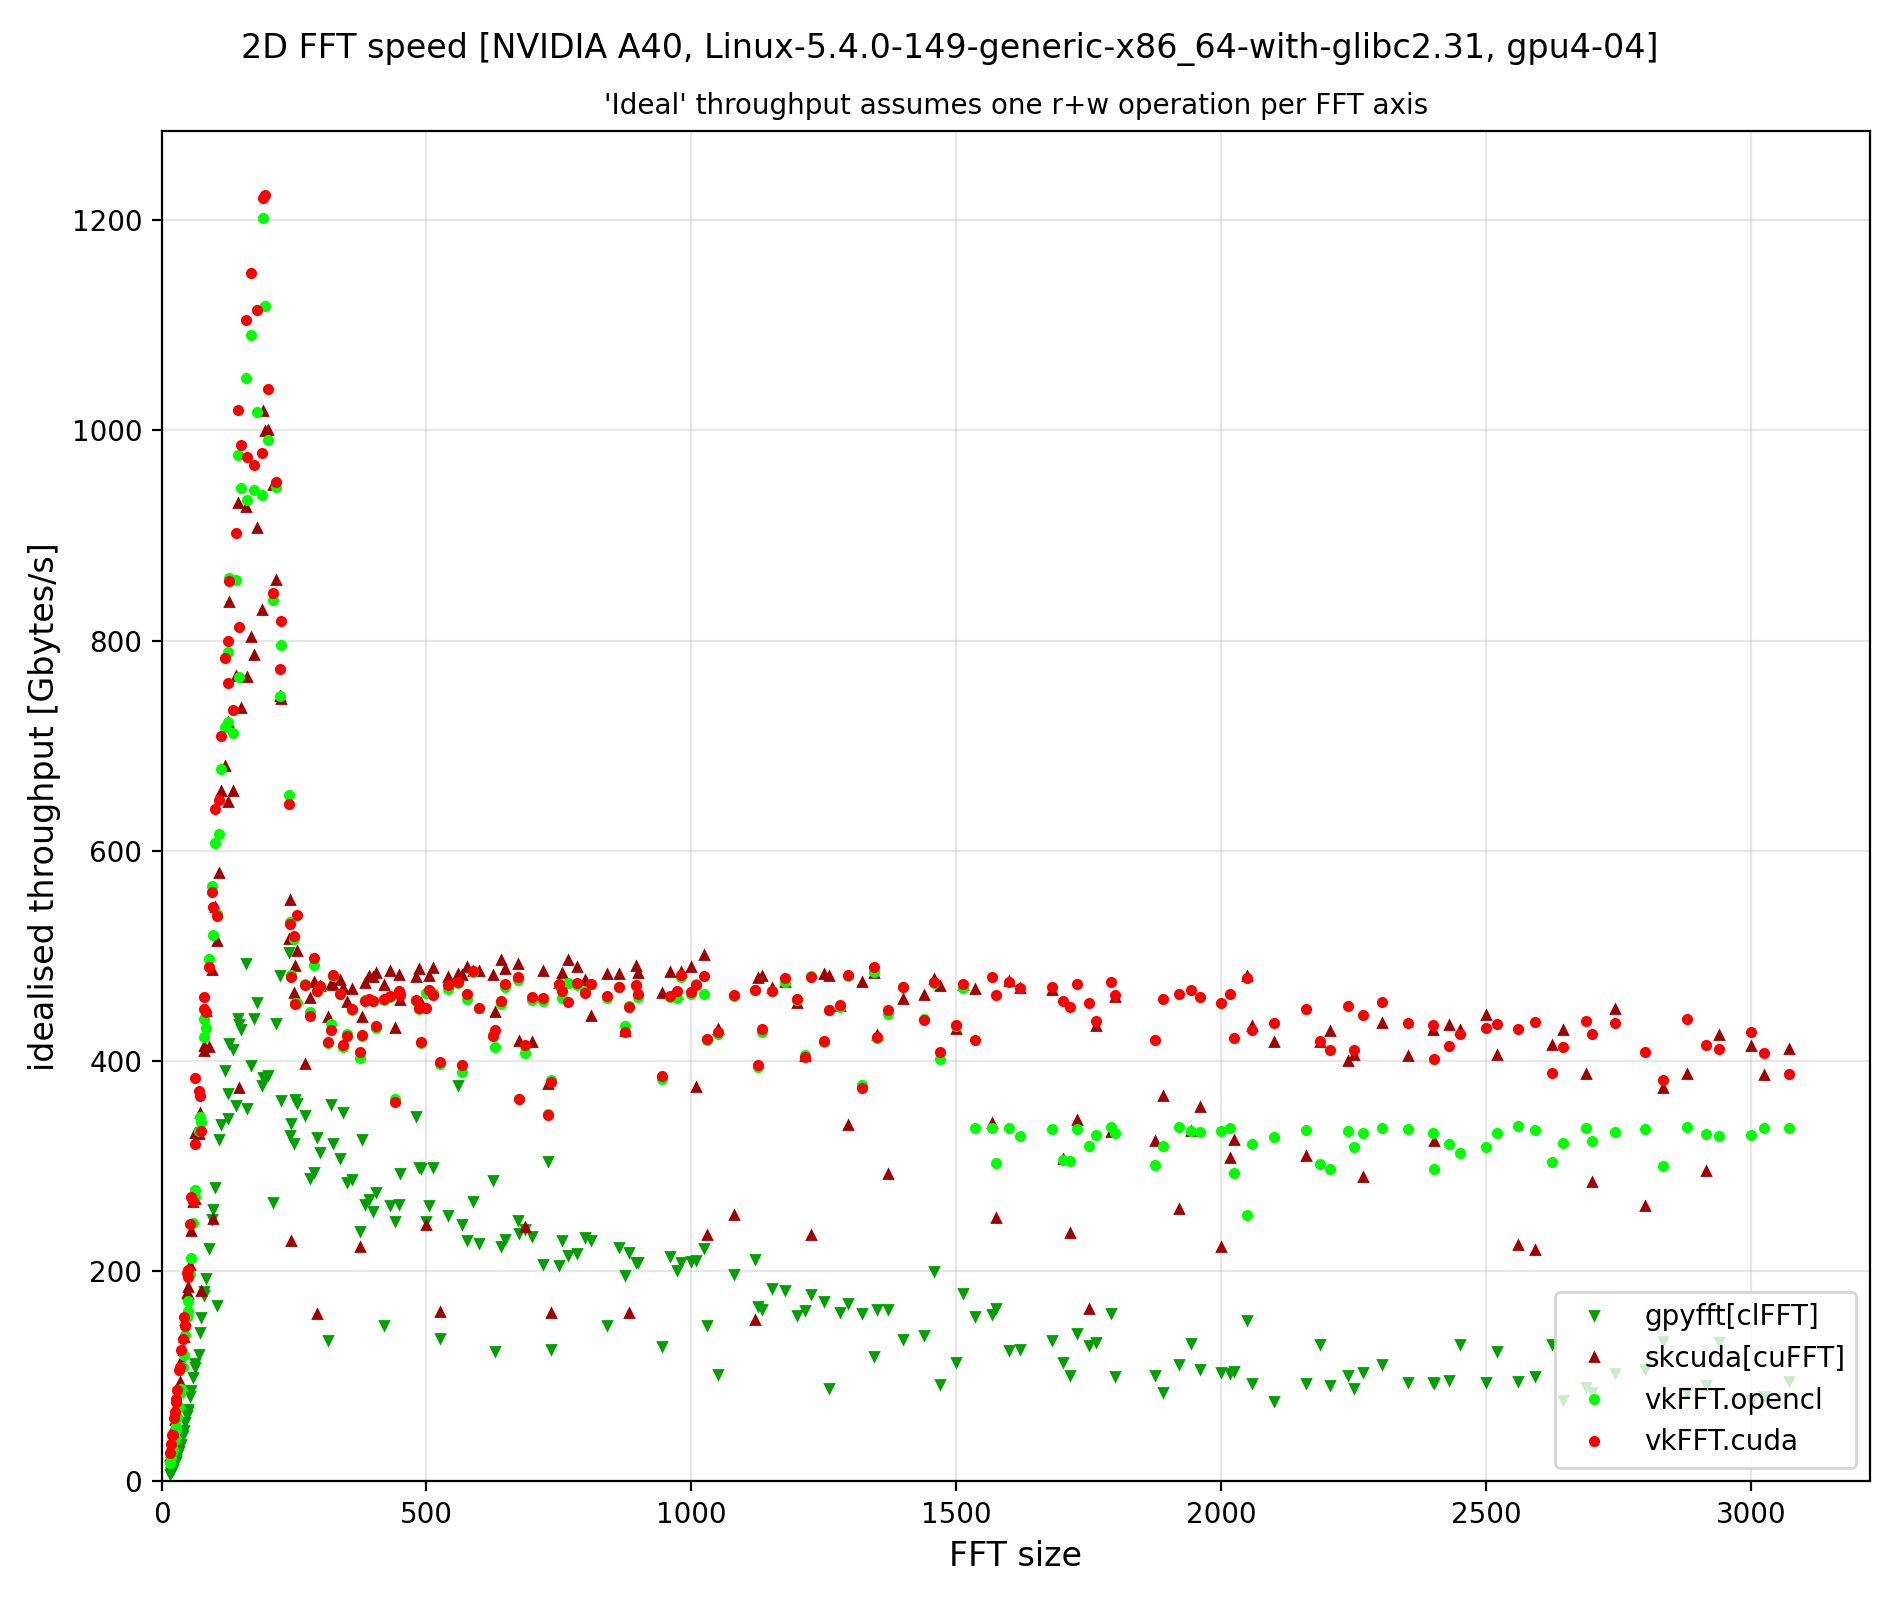

Gbytes/s and time given for a couple (FFT, iFFT), dtype=complex64

  16 x   N x   N [2D]     vkFFT.opencl      gpyfft[clFFT]         vkFFT.cuda      skcuda[cuFFT]  
  16 x  16 x   16        17.37 [ 14.05 µs]   7.43 [ 32.87 µs]  26.93 [  9.07 µs]  23.83 [ 10.24 µs]  [nb=1000]
  16 x  18 x   18        22.08 [ 13.99 µs]   9.27 [ 33.34 µs]  35.83 [  8.62 µs]  27.95 [ 11.06 µs]  [nb=1000]
  16 x  20 x   20        27.68 [ 13.78 µs]  11.35 [ 33.62 µs]  44.56 [  8.56 µs]  35.40 [ 10.77 µs]  [nb=1000]
  16 x  21 x   21        30.73 [ 13.69 µs]  12.28 [ 34.25 µs]  44.27 [  9.50 µs]  37.12 [ 11.33 µs]  [nb=1000]
  16 x  24 x   24        38.59 [ 14.23 µs]  16.41 [ 33.47 µs]  60.57 [  9.07 µs]  52.16 [ 10.53 µs]  [nb=1000]
  16 x  25 x   25        41.75 [ 14.28 µs]  17.21 [ 34.63 µs]  65.74 [  9.07 µs]  58.28 [ 10.23 µs]  [nb=1000]
  16 x  27 x   27        49.26 [ 14.11 µs]  19.91 [ 34.92 µs]  75.13 [  9.25 µs]  67.06 [ 10.37 µs]  [nb=1000]
  16 x  28 x   28        52.65 [ 14.20 µs]  21.57 [ 34.66 

  16 x 343 x  343       413.13 [271.58 µs] 351.23 [319.45 µs] 415.23 [270.21 µs] 469.14 [239.16 µs]  [nb=  89]
  16 x 350 x  350       425.37 [274.64 µs] 285.35 [409.40 µs] 423.67 [275.74 µs] 456.04 [256.17 µs]  [nb=  86]
  16 x 360 x  360       448.57 [275.53 µs] 288.05 [429.07 µs] 449.07 [275.22 µs] 468.74 [263.68 µs]  [nb=  81]
  16 x 375 x  375       402.62 [333.09 µs] 238.22 [562.97 µs] 408.95 [327.94 µs] 223.25 [600.72 µs]  [nb=  75]
  16 x 378 x  378       424.27 [321.18 µs] 325.78 [418.27 µs] 424.91 [320.69 µs] 441.49 [308.65 µs]  [nb=  73]
  16 x 384 x  384       457.72 [307.23 µs] 264.06 [532.55 µs] 457.16 [307.60 µs] 474.51 [296.36 µs]  [nb=  71]
  16 x 392 x  392       458.17 [319.85 µs] 269.06 [544.65 µs] 458.65 [319.52 µs] 480.94 [304.71 µs]  [nb=  68]
  16 x 400 x  400       456.98 [333.91 µs] 257.47 [592.64 µs] 457.56 [333.48 µs] 480.03 [317.87 µs]  [nb=  66]
  16 x 405 x  405       430.97 [362.96 µs] 275.48 [567.83 µs] 433.71 [360.67 µs] 484.01 [323.19 µs]  [nb=  64]
 

  16 x1350 x 1350       421.71 [  4.12 ms] 164.06 [ 10.59 ms] 422.59 [  4.11 ms] 424.84 [  4.09 ms]  [nb=   6]
  16 x1372 x 1372       445.03 [  4.03 ms] 164.17 [ 10.93 ms] 448.89 [  4.00 ms] 292.32 [  6.14 ms]  [nb=   6]
  16 x1400 x 1400       470.34 [  3.97 ms] 135.43 [ 13.80 ms] 470.67 [  3.97 ms] 458.68 [  4.08 ms]  [nb=   5]
  16 x1440 x 1440       439.82 [  4.50 ms] 139.45 [ 14.18 ms] 438.70 [  4.51 ms] 463.12 [  4.27 ms]  [nb=   5]
  16 x1458 x 1458       474.52 [  4.27 ms] 200.25 [ 10.12 ms] 475.15 [  4.27 ms] 477.82 [  4.24 ms]  [nb=   5]
  16 x1470 x 1470       401.99 [  5.13 ms]  92.36 [ 22.31 ms] 408.39 [  5.05 ms] 471.70 [  4.37 ms]  [nb=   5]
  16 x1500 x 1500       433.46 [  4.95 ms] 113.83 [ 18.85 ms] 434.49 [  4.94 ms] 430.91 [  4.98 ms]  [nb=   5]
  16 x1512 x 1512       469.40 [  4.64 ms] 179.66 [ 12.14 ms] 473.55 [  4.60 ms] 472.05 [  4.62 ms]  [nb=   5]
  16 x1536 x 1536       336.38 [  6.69 ms] 157.13 [ 14.32 ms] 420.35 [  5.35 ms] 468.69 [  4.80 ms]  [nb=   4]
 

In [3]:
ndim = 2              # Dimensions for the FFT (1, 2 or 3)
nmax = 3072           # Maximum FFT size (e.g. 512 for 3D, 4096 for 2D,...) - nmax is included
dtype = np.complex64  # Data type
radix_max = 7         # Largest allowed prime factor: use 2 for quick tests or 7 (13 is also possible)
cl_platform = None    # If None, the first OpenCL platform with a GPU is selected. Otherwise match part of the platform name


nb_repeat = 3         # Perform nb_repeat tests, keep best time

# number of parallel arrays for 2D (nz, n, n) and 1D (nz, nz, n) transforms
nz = 16               

plt.figure(figsize=(9.5, 8))

results = {"n": []}
if "vkFFT.opencl" not in results and has_pyvkfft_opencl:
    results["vkFFT.opencl"] = []
    results["vkFFT.opencl-dt"] = []
if "gpyfft[clFFT]" not in results and has_gpyfft:
    results["gpyfft[clFFT]"] = []
    results["gpyfft[clFFT]-dt"] = []
if "vkFFT.cuda" not in results and has_pyvkfft_cuda:
    results["vkFFT.cuda"] = []
    results["vkFFT.cuda-dt"] = []
if "skcuda[cuFFT]" not in results and has_skcuda:
    results["skcuda[cuFFT]"] = []
    results["skcuda[cuFFT]-dt"] = []
    plans_skcuda = []

if ndim == 1:
    header_results = "%4d x%4d x%4s [%dD]" % (nz, nz, "N", ndim)
elif ndim ==2:
    header_results = "%4d x%4s x%4s [%dD]" % (nz, "N", "N", ndim)
else:
    header_results = "%4s x%4s x%4s [%dD]" % ("N", "N", "N", ndim)
for b in results.keys():
    if b != "n" and "-dt" not in b:
        header_results += "%17s  " % b


print("Gbytes/s and time given for a couple (FFT, iFFT), dtype=%s" % np.dtype(np.complex64).name)
print()
print(header_results)


# Only test up to prime factors equal to 7 (cuFFT)
for n in range(16, nmax+1):
    if max(primes(n)) > radix_max:
        continue
    results["n"].append(n)
    # Estimate number of repeats to last 0.1s with at least 100 GB/s
    nb = int(round(0.1 * 100 / (nz**(3-ndim) * n ** ndim * np.dtype(dtype).itemsize * ndim * 2 * 2 / 1024 ** 3)))
    nb = max(nb, 1)
    nb = min(nb, 1000)
    # print("%4d (nb=%4d)"%(n, nb))
    
    if ndim == 1:
        sh = nz, nz, n
    elif ndim == 2:
        sh = nz, n, n
    else:
        sh = n, n, n
    
    # OpenCL backends
    if has_pyvkfft_opencl or has_gpyfft:
        d = clrandom.rand(cq, shape=sh, dtype=np.float32).astype(dtype)
    
    if has_pyvkfft_opencl:
        dt = 0
        try:
            app= clVkFFTApp(d.shape, d.dtype, queue=cq, ndim=ndim)
            for i in range(nb_repeat):
                cq.finish()
                t0 = timeit.default_timer()
                for i in range(nb):
                    d = app.ifft(d)
                    d = app.fft(d)
                cq.finish()
                dt1 = timeit.default_timer() - t0
                if dt == 0:
                    dt = dt1
                elif dt1< dt:
                    dt = dt1
            #print("%4d %4dx%4d 2D FFT+iFFT dt=%6.2f ms %7.2f Gbytes/s [pyvkfft.opencl]  [nb=%4d]" %
            #      (nz, n, n, dt / nb * 1000, gbps, nb))
            del app
            gbps = d.nbytes * nb * ndim * 2 * 2 / dt / 1024 ** 3
        except:
            gbps = 0
        results["vkFFT.opencl"].append(gbps)
        results["vkFFT.opencl-dt"].append(dt)
        gc.collect()
    
    if has_gpyfft:
        dt = 0
        for axes in permutations([-1, -2, -3][:ndim]):
            gpyfft_plan = gpyfft.FFT(cl_ctx, cq, d, None, axes=axes)
            # Shuffle axes order to find fastest transform
            for i in range(nb_repeat):
                cq.finish()
                t0 = timeit.default_timer()
                for i in range(nb):
                    gpyfft_plan.enqueue(forward=True)
                    gpyfft_plan.enqueue(forward=False)
                cq.finish()
                dt1 = timeit.default_timer() - t0
                if dt == 0:
                    dt = dt1
                elif dt1< dt:
                    dt = dt1
            del gpyfft_plan
        gbps = d.nbytes * nb * ndim * 2 * 2 / dt / 1024 ** 3
        #print("%4d %4dx%4d 2D FFT+iFFT dt=%6.2f ms %7.2f Gbytes/s [gpyfft[clFFT]]  [nb=%4d]" %
        #      (nz, n, n, dt / nb * 1000, gbps, nb))
        results["gpyfft[clFFT]"].append(gbps)
        results["gpyfft[clFFT]-dt"].append(dt)

    if has_pyvkfft_opencl or has_gpyfft:
        d.data.release()
        del d
        gc.collect()
    
    # CUDA backends
    if has_pyvkfft_cuda or has_pyvkfft_cuda:
        d = curandom.rand(shape=sh, dtype=np.float32).astype(dtype)

    if has_pyvkfft_cuda:
        try:
            app= cuVkFFTApp(d.shape, d.dtype, ndim=ndim)
            dt = 0
            for i in range(nb_repeat):
                cu_ctx.synchronize()
                t0 = timeit.default_timer()
                for i in range(nb):
                    d = app.ifft(d)
                    d = app.fft(d)
                cu_ctx.synchronize()
                dt1 = timeit.default_timer() - t0
                if dt == 0:
                    dt = dt1
                elif dt1< dt:
                    dt = dt1
            #print("%4d %4dx%4d 2D FFT+iFFT dt=%6.2f ms %7.2f Gbytes/s [pyvkfft.cuda]    [nb=%4d]" %
            #      (nz, n, n, dt / nb * 1000, gbps, nb))
            del app
            gbps = d.nbytes * nb * ndim * 2 * 2 / dt / 1024 ** 3
        except:
            gbps = 0
        results["vkFFT.cuda"].append(gbps)
        results["vkFFT.cuda-dt"].append(dt)
        gc.collect()

    if has_skcuda:
        if ndim == 1:
            plan = cu_fft.Plan(n, dtype, dtype, batch=nz*nz)
        elif ndim == 2:
            plan = cu_fft.Plan((n,n), dtype, dtype, batch=nz)
        else:
            plan = cu_fft.Plan((n,n,n), dtype, dtype, batch=1)
        dt = 0
        for i in range(nb_repeat):
            cu_ctx.synchronize()
            t0 = timeit.default_timer()
            for i in range(nb):
                cu_fft.fft(d, d, plan)
                cu_fft.ifft(d, d, plan)
            cu_ctx.synchronize()
            dt1 = timeit.default_timer() - t0
            if dt == 0:
                dt = dt1
            elif dt1< dt:
                dt = dt1
        gbps = d.nbytes * nb * ndim * 2 * 2 / dt / 1024 ** 3
        #print("%4d %4dx%4d 2D FFT+iFFT dt=%6.2f ms %7.2f Gbytes/s [skcuda[cuFFT]]    [nb=%4d]" %
        #      (nz, n, n, dt / nb * 1000, gbps, nb))
        # del plan
        plans_skcuda.append(plan)  # We can't destroy skcuda plans (bug in cufft)
        results["skcuda[cuFFT]"].append(gbps)
        results["skcuda[cuFFT]-dt"].append(dt)

        
    if has_pyvkfft_cuda or has_pyvkfft_cuda:
        d.gpudata.free()
        del d
        gc.collect()
    
    # text output
    r = "%4d x%4d x %4d      " % sh
    for b in results.keys():
        if b != "n" and "-dt" not in b:
            dt = results[b+'-dt'][-1] / nb
            if dt < 1e-3 :
                r += "%7.2f [%6.2f µs]" % (results[b][-1], dt * 1e6)
            elif dt > 1:
                r += "%7.2f [%6.2f  s]" % (results[b][-1], dt)
            else:
                r += "%7.2f [%6.2f ms]" % (results[b][-1], dt * 1000)
    print(r + "  [nb=%4d]"%nb)

    
    plt.clf()
    x = results['n']
    if "gpyfft[clFFT]" in results:
        y = results["gpyfft[clFFT]"]
        plt.plot(x, y, color='#00A000', marker='v', markersize=3, linestyle='', label="gpyfft[clFFT]")
    if "skcuda[cuFFT]" in results:
        y = results["skcuda[cuFFT]"]
        plt.plot(x, y, color='#A00000', marker='^', markersize=3, linestyle='', label="skcuda[cuFFT]")
    if "vkFFT.opencl" in results:
        y = results["vkFFT.opencl"]
        plt.plot(x, y, color='#00FF00', marker='o', markersize=3, linestyle='', label="vkFFT.opencl")
    if "vkFFT.cuda" in results:
        y = results["vkFFT.cuda"]
        plt.plot(x, y, color='#FF0000', marker='o', markersize=3, linestyle='', label="vkFFT.cuda")
    
    plt.legend(loc='lower right', fontsize=10)
    plt.xlabel("FFT size", fontsize=12)
    plt.ylabel("idealised throughput [Gbytes/s]", fontsize=12)
    plt.suptitle("%dD FFT speed [%s, %s, %s]" % (ndim, gpu_name_real, platform.platform(),
                                                 platform.node()), fontsize=12)
    plt.title("'Ideal' throughput assumes one r+w operation per FFT axis", fontsize=10)
    plt.grid(which='both', alpha=0.3)
    plt.xlim(0)
    plt.ylim(0)    
    plt.tight_layout()
    
    # Force refresh
    plt.draw()
    plt.gcf().canvas.draw()
    plt.pause(.001)

plt.savefig('benchmark-%dDFFT-%s-%s-%s.png'%(ndim, gpu_name_real.replace(' ','_'), 
                                             platform.platform(), platform.node()))
